In [1]:
import pandas as pd 
import h5py
import numpy as np 
from matplotlib import pyplot as plt

# LINCS PERTURBATION RELATIONS 

Future work: 
- consider using stimulatory/inhibitory relations (currently abs(score))

In [ ]:
# NOTE: ablation study suggests NPC and ASC are detrimental to perfomance. These will be removed. 
#       A549 "_rev" edge was also detrimental, however, we will remove that in `00_MAKE_TKG.ipynb`
VALID_CELL_LINES = ['MCF7', 'SKB', 'PC3', 'VCAP', 'PHH', 'HT29', 'A549', 'HA1E', 'A375']

SCORE_THRESHOLD = 5 # +/- 10 is most perturbed, 0 is unperturbed

In [3]:
siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)
siginfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0


In [4]:
drugspace = np.loadtxt('../../extdata/meta/drugspace.txt', dtype=str)
druginfo = pd.read_csv('../../../data/compoundinfo_beta.txt', sep='\t', low_memory=False)[lambda x: x.inchi_key.isin(drugspace)]
pertid_space = druginfo.pert_id.unique()
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
37,BRD-K87737963,CYT-387,NaN,NaN,O=C(NCC#N)c1ccc(cc1)-c1ccnc(Nc2ccc(cc2)N2CCOCC...,ZVHNDZWQTBEVRY-UHFFFAOYSA-N,momelotinib
508,BRD-K62391742,GDC-0199,NaN,NaN,CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3cc...,LQBVNQSMGBZMKD-UHFFFAOYSA-N,venetoclax
610,BRD-K70301465,ibrutinib,BTK,BTK inhibitor,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)[C@@H]1C...,XYFPWWZEPKGCCK-GOSISDBHSA-N,PCI-32765
627,BRD-K42828737,sunitinib,FLT1,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate
628,BRD-K42828737,sunitinib,FLT3,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate


In [5]:
siginfo = siginfo[lambda x: x.pert_id.isin(pertid_space) & (x.pert_dose == 10.) & (x.pert_time == 24.)]
siginfo = siginfo[lambda x: x.is_exemplar_sig == 1]
siginfo.shape 

(844, 37)

In [6]:
# only include cell lines if there are at least 25 exemplar signatures
#cell_lines = siginfo.groupby('cell_iname').count()[['sig_id']].sort_values('sig_id', ascending=False)[lambda x: x.sig_id > 5].index.tolist()
#print('# cell lines:', len(cell_lines))

siginfo = siginfo[lambda x: x.cell_iname.isin(VALID_CELL_LINES)]
drugs = siginfo.pert_id.unique()
print('# drugs:', len(drugs))
siginfo.shape

# drugs: 78


(290, 37)

In [7]:
siginfo = siginfo.groupby(['cell_iname', 'pert_id']).first().reset_index()
siginfo.shape

(290, 37)

In [8]:
hdf = h5py.File('../../../data/level5_beta_trt_cp_n720216x12328.gctx')

In [9]:
hdf_ids = hdf['0']['META']['COL']['id'][...].astype(str)
hdf_genes = hdf['0']['META']['ROW']['id'][...].astype(str)

In [10]:
geneinfo = pd.read_csv('../../../data/geneinfo_beta.txt', sep='\t', low_memory=False)
geneinfo.gene_id = geneinfo.gene_id.astype(str)
geneinfo.head()

,gene_id,gene_symbol,ensembl_id,gene_title,gene_type,src,feature_space
0,750,GAS8-AS1,ENSG00000221819,GAS8 antisense RNA 1,ncRNA,NCBI,inferred
1,6315,ATXN8OS,NaN,ATXN8 opposite strand lncRNA,ncRNA,NCBI,inferred
2,7503,XIST,ENSG00000229807,X inactive specific transcript,ncRNA,NCBI,inferred
3,8552,INE1,ENSG00000224975,inactivation escape 1,ncRNA,NCBI,inferred
4,9834,FAM30A,ENSG00000226777,family with sequence similarity 30 member A,ncRNA,NCBI,inferred


In [11]:
sig2hdfix = {sig: i for i, sig in enumerate(hdf_ids)}
idxs = [sig2hdfix[sig] for sig in siginfo.sig_id.values]
sorting_ixs = np.argsort(idxs)
sorted_idxs = np.array(idxs)[sorting_ixs]
sorted_sigids= siginfo.sig_id.values[sorting_ixs]

In [12]:
x = hdf['0']['DATA']['0']['matrix'][sorted_idxs]
x.shape

(290, 12328)

In [13]:
res = pd.DataFrame(x, columns=hdf_genes, index=sorted_sigids).unstack().reset_index().rename({'level_0':'gene_id', 'level_1':'sig_id', 0:'score'}, axis=1)
res = res.merge(geneinfo[['gene_id', 'gene_symbol', 'feature_space', 'gene_type']], on='gene_id', how='inner')
res = res[lambda x: x.feature_space.isin(['best inferred', 'landmark']) & (x.gene_type == 'protein-coding')]
res = res.merge(siginfo[['cell_iname', 'pert_id', 'sig_id']], on='sig_id', how='inner')
res = res.merge(druginfo[['pert_id', 'inchi_key']], on='pert_id', how='inner')
res.head()

,gene_id,sig_id,score,gene_symbol,feature_space,gene_type,cell_iname,pert_id,inchi_key
0,100,ASG002_A549_24H:H04,1.14860,ADA,best inferred,protein-coding,A549,BRD-K02113016,FDLYAMZZIXQODN-UHFFFAOYSA-N
1,100,ASG002_A549_24H:H04,1.14860,ADA,best inferred,protein-coding,A549,BRD-K02113016,FDLYAMZZIXQODN-UHFFFAOYSA-N
2,100,ASG002_MCF7_24H:D22,0.35843,ADA,best inferred,protein-coding,MCF7,BRD-K92723993,KTUFNOKKBVMGRW-UHFFFAOYSA-N
3,100,ASG002_MCF7_24H:D22,0.35843,ADA,best inferred,protein-coding,MCF7,BRD-K92723993,KTUFNOKKBVMGRW-UHFFFAOYSA-N
4,100,ASG002_MCF7_24H:D22,0.35843,ADA,best inferred,protein-coding,MCF7,BRD-K92723993,KTUFNOKKBVMGRW-UHFFFAOYSA-N


In [14]:
kg_geneinfo = pd.read_csv('../../extdata/meta/gene2aa.csv')
genespace = kg_geneinfo.gene_name.unique()
kg_geneinfo.head()

,gene_name,id,organism,sequence
0,A1BG,sp|P04217|A1BG_HUMAN,Homo sapiens,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
1,A1CF,sp|Q9NQ94|A1CF_HUMAN,Homo sapiens,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...
2,A2M,sp|P01023|A2MG_HUMAN,Homo sapiens,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...
3,A3GALT2,sp|U3KPV4|A3LT2_HUMAN,Homo sapiens,MALKEGLRAWKRIFWRQILLTLGLLGLFLYGLPKFRHLEALIPMGV...
4,A4GALT,sp|Q9NPC4|A4GAT_HUMAN,Homo sapiens,MSKPPDLLLRLLRGAPRQRVCTLFIIGFKFTFFVSIMIYWHVVGEP...


In [15]:
res = res[lambda x: x.gene_symbol.isin(genespace)]
res.gene_symbol.nunique()

7872

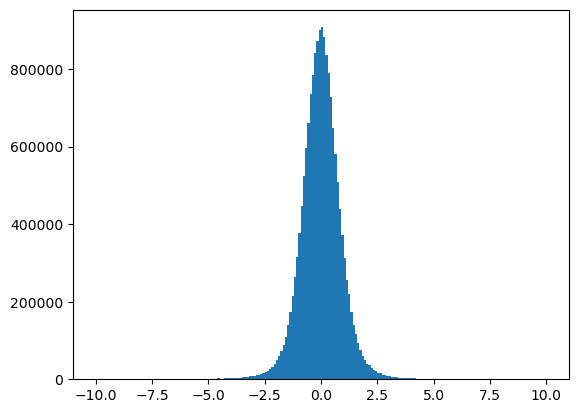

In [16]:
plt.figure()
plt.hist(res.score.values, bins=200)
plt.show()

In [17]:
res = res.assign(perturbed = (res.score < -SCORE_THRESHOLD) | (res.score > SCORE_THRESHOLD))

In [18]:
for cell in VALID_CELL_LINES: 

    relations_fwd = res[lambda x: (x.cell_iname == cell) & x.perturbed]
    relations_fwd = relations_fwd[['inchi_key', 'gene_symbol']].rename({'inchi_key':'src', 'gene_symbol':'dst'}, axis=1)
    relations_fwd = relations_fwd.assign(src_type = 'drug', dst_type = 'gene', relation=f'{cell}_lincs_perturbation_fwd')
    relations_fwd = relations_fwd.drop_duplicates()
    relations_fwd.to_csv(f'../../extdata/relations/{cell}_lincs_perturbation_fwd.csv', index=False)

    relations_rev = res[lambda x: (x.cell_iname == cell) & x.perturbed]
    relations_rev = relations_rev[['inchi_key', 'gene_symbol']].rename({'inchi_key':'dst', 'gene_symbol':'src'}, axis=1)
    relations_rev = relations_rev.assign(dst_type = 'drug', src_type = 'gene', relation=f'{cell}_lincs_perturbation_rev')
    relations_rev = relations_rev.drop_duplicates()
    relations_rev.to_csv(f'../../extdata/relations/{cell}_lincs_perturbation_rev.csv', index=False)

    print(cell, relations_fwd.shape[0])

MCF7 391
SKB 254
PC3 335
VCAP 209
PHH 297
HT29 1127
A549 457
HA1E 633
A375 847
